# Introduction

## Problem Objective
This project aims to explore and model human behavior based on personality types — **extroverts** and **introverts** — using survey data.  
Our goal is to predict personality using behavioral and lifestyle indicators. This type of analysis can be helpful in personalized recommendations, HR screening, or mental health support tools.

> **Goal:** Predict whether a person is an extrovert or introvert based on their responses to behavioral questions.

---

## Data Characteristics
- **Dataset Source:** [Extrovert vs. Introvert Behavior Data on Kaggle](https://www.kaggle.com/datasets/rakeshkapilavai/extrovert-vs-introvert-behavior-data)
- The dataset contains answers to a series of survey questions related to:
  - **Lifestyle habits**
  - **Communication preferences**
  - **Mood and social interactions**


### Key Columns Overview

| Column Name                   | Description                                                                 |
|------------------------------|-----------------------------------------------------------------------------|
| `id`                         | Unique identifier for each individual record                                |
| `Time_spent_Alone`           | Number of hours spent alone per day                                        |
| `Stage_fear`                 | Whether the person has a fear of public speaking (`Yes`/`No`)              |
| `Social_event_attendance`    | Average number of social events attended per month                         |
| `Going_outside`              | Average number of days per week the person goes outside                    |
| `Drained_after_socializing` | Whether the person feels mentally drained after social interactions (`Yes`/`No`) |
| `Friends_circle_size`        | Number of close friends the person has                                     |
| `Post_frequency`             | Average number of social media posts per month                             |
| `Personality`                | Target variable: Personality type (`Introvert` or `Extrovert`)             |

# Preparation

In [27]:
# Core libraries
import pandas as pd
import numpy as np
import warnings

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn: model selection, preprocessing, metrics
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    StratifiedKFold
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)

# Gradient-boosting libraries
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import xgboost as xgb
import lightgbm as lgb

# SHAP for model interpretation
import shap

# Settings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
sns.set(style="whitegrid")

# Jupyter magic
%matplotlib inline

In [28]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e7/sample_submission.csv
/kaggle/input/playground-series-s5e7/train.csv
/kaggle/input/playground-series-s5e7/test.csv


# Load Data
Here, we will load both the training data and the test data, and then combine them to provide a more complete analysis of the data.

In [29]:
# Load the data
train_data_path = '../input/playground-series-s5e7/train.csv'
train_data = pd.read_csv(train_data_path)

# Load the dataset
train = pd.read_csv("/kaggle/input/playground-series-s5e7/train.csv")
test  = pd.read_csv("/kaggle/input/playground-series-s5e7/test.csv")

In [30]:
# Preview the original training data
train.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert


In [31]:
# Preview the original testing data
test.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency
0,18524,3.0,No,7.0,4.0,No,6.0,NaN
1,18525,NaN,Yes,0.0,0.0,Yes,5.0,1.0
2,18526,3.0,No,5.0,6.0,No,15.0,9.0
3,18527,3.0,No,4.0,4.0,No,5.0,6.0
4,18528,9.0,Yes,1.0,2.0,Yes,1.0,1.0


In [32]:
# Add 'source' column for tracking
train['source'] = 'train'
test['source'] = 'test'

# Combine train and test datasets for single data preprocessing
df = pd.concat([train, test], axis=0).reset_index(drop=True)

# Preview the whole data
df.head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality,source
0,0,0.0,No,6.0,4.0,No,15.0,5.0,Extrovert,train
1,1,1.0,No,7.0,3.0,No,10.0,8.0,Extrovert,train
2,2,6.0,Yes,1.0,0.0,NaN,3.0,0.0,Introvert,train
3,3,3.0,No,7.0,3.0,No,11.0,5.0,Extrovert,train
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert,train


# Inspection
Here, we inspect for each numerical and categorical columns in the dataset. We also check for missing values and the shape of the dataset.

In [33]:
# Display the shape
print("Dataset shape:", df.shape)

Dataset shape: (24699, 10)


In [34]:
# Check column types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24699 entries, 0 to 24698
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         24699 non-null  int64  
 1   Time_spent_Alone           23084 non-null  float64
 2   Stage_fear                 22208 non-null  object 
 3   Social_event_attendance    23122 non-null  float64
 4   Going_outside              22767 non-null  float64
 5   Drained_after_socializing  23118 non-null  object 
 6   Friends_circle_size        23295 non-null  float64
 7   Post_frequency             23027 non-null  float64
 8   Personality                18524 non-null  object 
 9   source                     24699 non-null  object 
dtypes: float64(5), int64(1), object(4)
memory usage: 1.9+ MB


In [35]:
# Identify numerical and categorical columns
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

print("Numerical Columns:", numerical_cols)
print("Categorical Columns:", categorical_cols)

Numerical Columns: ['id', 'Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']
Categorical Columns: ['Stage_fear', 'Drained_after_socializing', 'Personality', 'source']


In [36]:
# Check for missing values
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 'Percentage': missing_percent})
missing_df = missing_df[missing_df['Missing Values'] > 0]
missing_df

,Missing Values,Percentage
Time_spent_Alone,1615,6.538726
Stage_fear,2491,10.085429
Social_event_attendance,1577,6.384874
Going_outside,1932,7.822179
Drained_after_socializing,1581,6.401069
Friends_circle_size,1404,5.684441
Post_frequency,1672,6.769505
Personality,6175,25.001012


In [37]:
# Descriptive statistics for numerical columns
df[numerical_cols].describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,24699.000000,23084.000000,23122.000000,22767.000000,23295.000000,23027.000000
mean,12349.000000,3.132559,5.270824,4.042693,7.999657,4.993833
std,7130.131485,2.999230,2.754491,2.058194,4.215721,2.876184
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6174.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,12349.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,18523.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [38]:
# Descriptive statistics for categorical columns
df[categorical_cols].describe()

,Stage_fear,Drained_after_socializing,Personality,source
count,22208,23118,18524,24699
unique,2,2,2,2
top,No,No,Extrovert,train
freq,16845,17750,13699,18524


In [39]:
# Unique value counts for categorical columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())


Unique values in 'Stage_fear':
Stage_fear
No     16845
Yes     5363
Name: count, dtype: int64

Unique values in 'Drained_after_socializing':
Drained_after_socializing
No     17750
Yes     5368
Name: count, dtype: int64

Unique values in 'Personality':
Personality
Extrovert    13699
Introvert     4825
Name: count, dtype: int64

Unique values in 'source':
source
train    18524
test      6175
Name: count, dtype: int64


# Exploration
## Target Variable Distribution
We begin by analyzing the distribution of our target variable, Personality, to see if the dataset is balanced between Extrovert and Introvert.

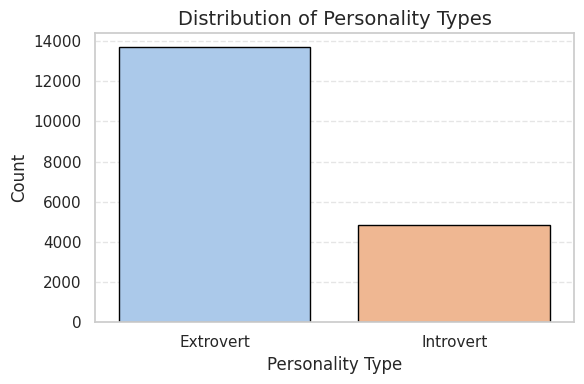


📊 Personality Value Counts (Proportions):
Personality
Extrovert    0.74
Introvert    0.26
Name: proportion, dtype: float64


In [40]:
# Target Variable Distribution

plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Personality', palette='pastel', edgecolor='black')
plt.title('Distribution of Personality Types', fontsize=14)
plt.xlabel('Personality Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# Display normalized value counts (as proportions)
print("\n📊 Personality Value Counts (Proportions):")
print(df['Personality'].value_counts(normalize=True).round(3))

## Distribution of Numerical Features
Next, we explore the distribution of the numerical features using histograms. This helps us understand the spread and skewness of the data.

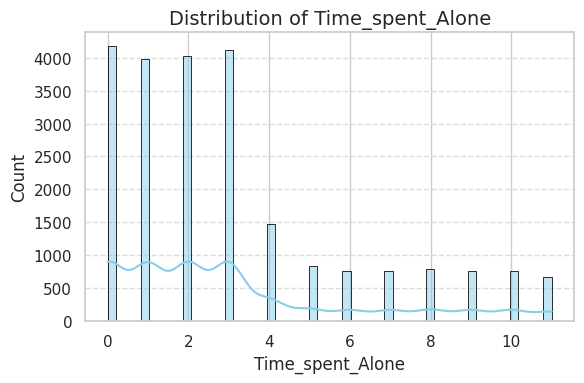


Descriptive Stats for Time_spent_Alone:

count    23084.000000
mean         3.132559
std          2.999230
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         11.000000
Name: Time_spent_Alone, dtype: float64 
----------------------------------------


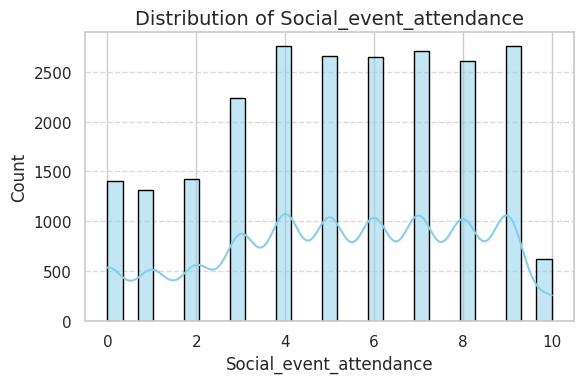


Descriptive Stats for Social_event_attendance:

count    23122.000000
mean         5.270824
std          2.754491
min          0.000000
25%          3.000000
50%          5.000000
75%          8.000000
max         10.000000
Name: Social_event_attendance, dtype: float64 
----------------------------------------


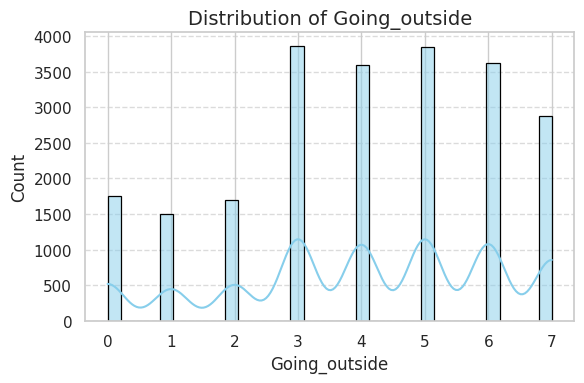


Descriptive Stats for Going_outside:

count    22767.000000
mean         4.042693
std          2.058194
min          0.000000
25%          3.000000
50%          4.000000
75%          6.000000
max          7.000000
Name: Going_outside, dtype: float64 
----------------------------------------


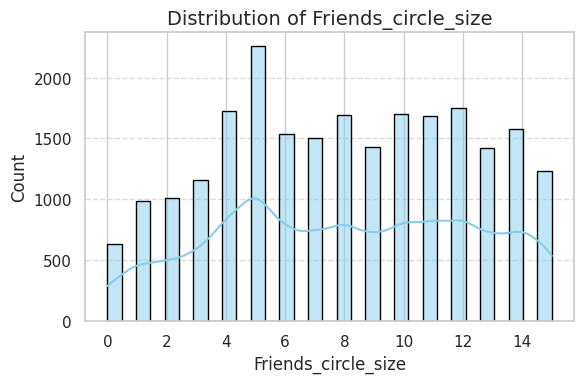


Descriptive Stats for Friends_circle_size:

count    23295.000000
mean         7.999657
std          4.215721
min          0.000000
25%          5.000000
50%          8.000000
75%         12.000000
max         15.000000
Name: Friends_circle_size, dtype: float64 
----------------------------------------


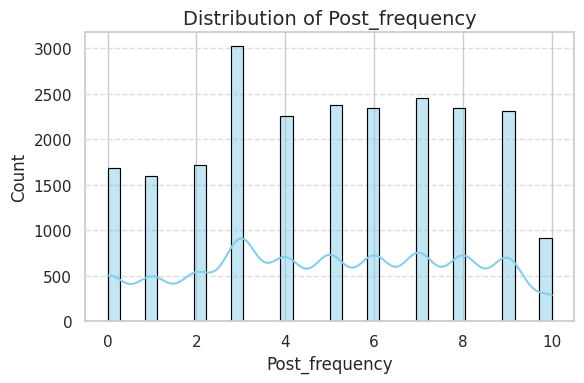


Descriptive Stats for Post_frequency:

count    23027.000000
mean         4.993833
std          2.876184
min          0.000000
25%          3.000000
50%          5.000000
75%          7.000000
max         10.000000
Name: Post_frequency, dtype: float64 
----------------------------------------


In [41]:
# Visualize Distribution of Numerical Features
num_cols = ['Time_spent_Alone', 'Social_event_attendance', 'Going_outside', 'Friends_circle_size', 'Post_frequency']

for col in num_cols:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, color='skyblue', edgecolor='black')
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Print descriptive statistics
    print(f'\nDescriptive Stats for {col}:\n')
    print(df[col].describe(), '\n' + '-'*40)

## Outlier Detection via Boxplots
We use boxplots to identify potential outliers in numerical features.

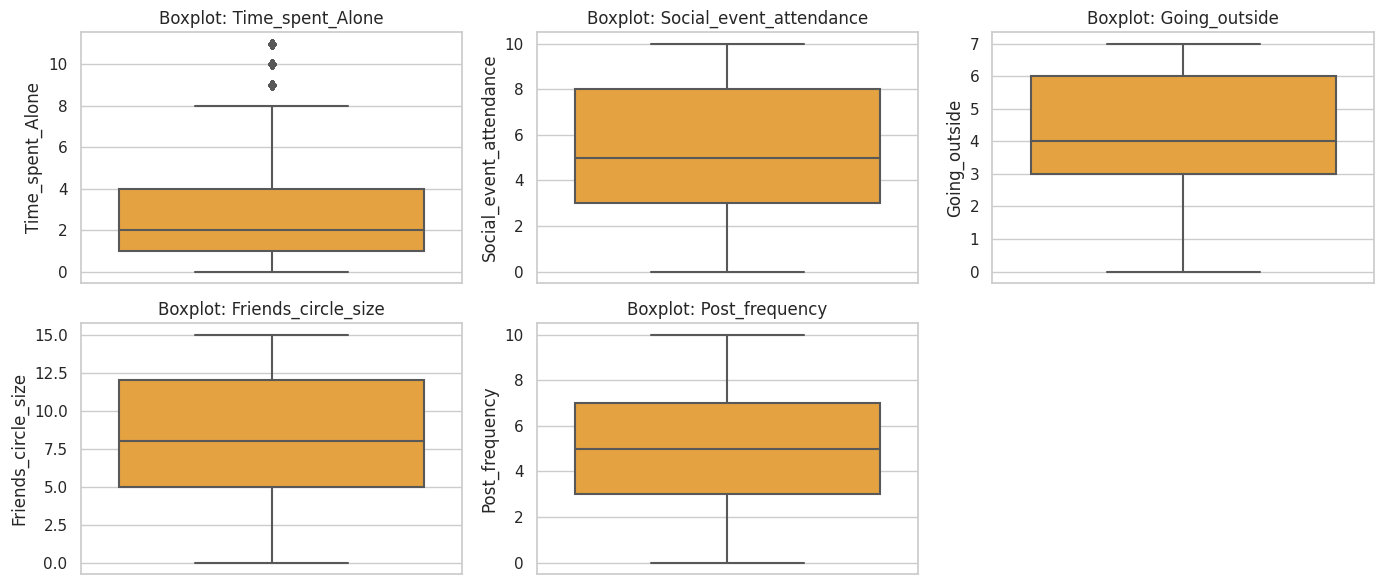

In [42]:
# Outlier detection
plt.figure(figsize=(14, 6))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(data=df, y=col, color='#FFA726')
    plt.title(f"Boxplot: {col}")
plt.tight_layout()
plt.show()

## Distribution of Categorical Features
We use countplots to examine the balance of categorical features: Stage_fear and Drained_after_socializing.

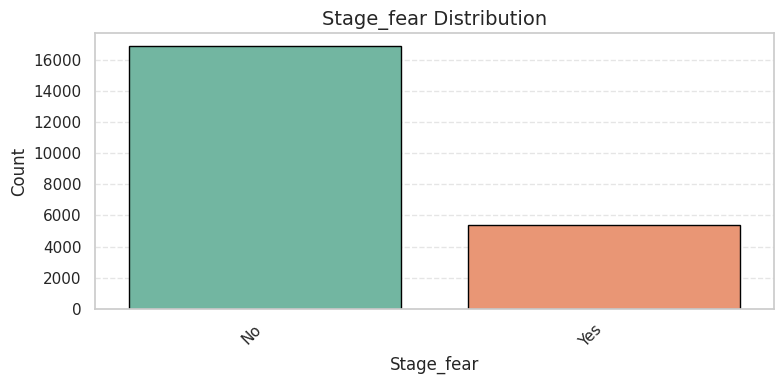


📊 Proportion of Each Category in "Stage_fear":

Stage_fear
No     0.759
Yes    0.241
Name: proportion, dtype: float64 
----------------------------------------


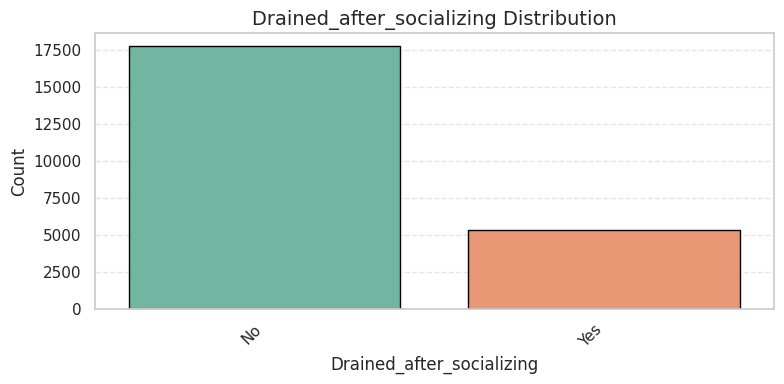


📊 Proportion of Each Category in "Drained_after_socializing":

Drained_after_socializing
No     0.768
Yes    0.232
Name: proportion, dtype: float64 
----------------------------------------


In [43]:
# Visualize Distribution of Categorical Features
cat_cols = ['Stage_fear', 'Drained_after_socializing']

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(
        data=df,
        x=col,
        order=df[col].value_counts().index,
        palette='Set2',
        edgecolor='black'
    )
    plt.title(f'{col} Distribution', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    print(f'\n📊 Proportion of Each Category in "{col}":\n')
    print(df[col].value_counts(normalize=True).round(3), '\n' + '-'*40)

## Correlation Between Numerical Features
A heatmap is plotted to assess correlations between numerical features, which may influence feature selection or interaction terms later.

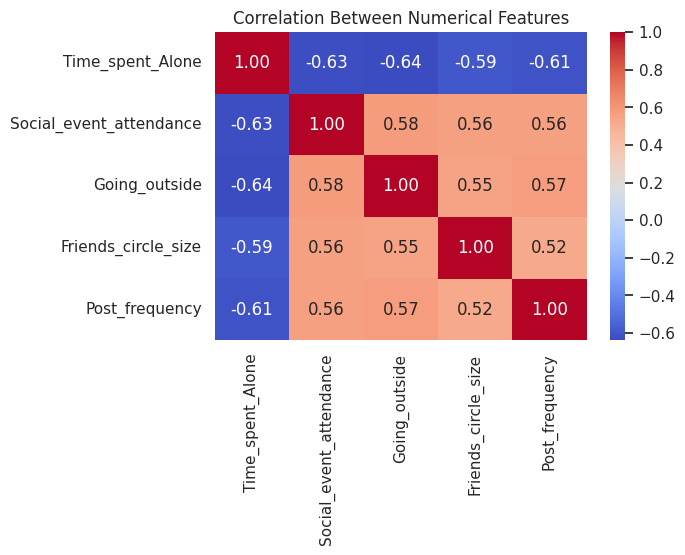

In [44]:
# Correlation between numerical columns
plt.figure(figsize=(6, 4))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Between Numerical Features")
plt.show()

## Categorical feature distribution grouped by Personality

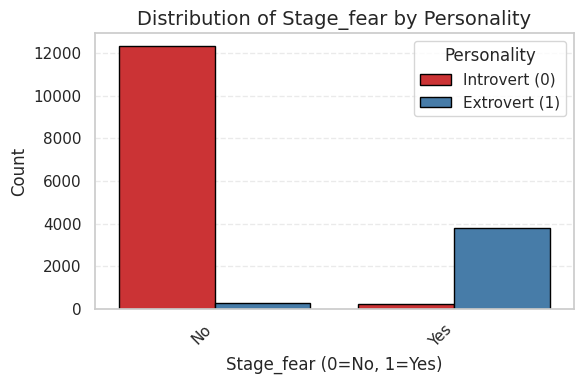

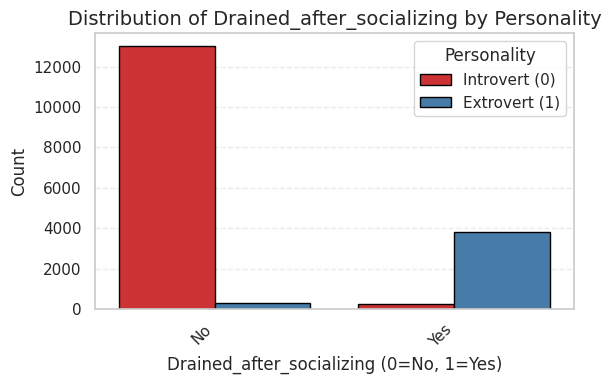

In [45]:
# Categorical feature distributions by Personality
for col, palette in zip(['Stage_fear', 'Drained_after_socializing'], ['Set1', 'Set1']):
    plt.figure(figsize=(6, 4))
    sns.countplot(
        data=df,
        x=col,
        hue='Personality',
        palette=palette,
        edgecolor='black'
    )
    plt.title(f'Distribution of {col} by Personality', fontsize=14)
    plt.xlabel(f'{col} (0=No, 1=Yes)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Personality', labels=['Introvert (0)', 'Extrovert (1)'])
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

## Numerical features grouped by Personality

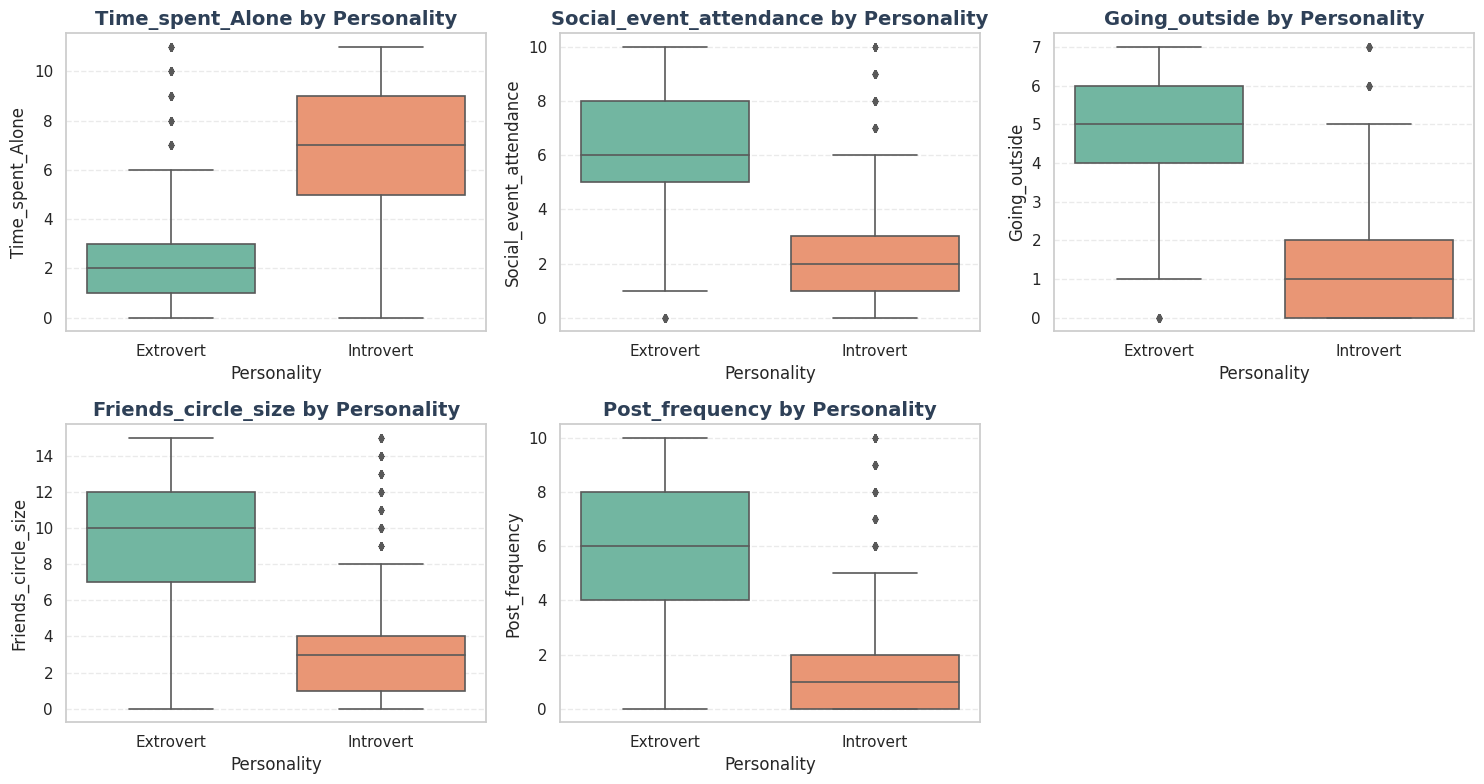

In [46]:
# Feature vs Target Relationship (Numerical Features by Personality)
plt.figure(figsize=(15, 8))
for i, col in enumerate(num_cols):
    plt.subplot(2, 3, i + 1)
    sns.boxplot(
        data=df,
        x='Personality',
        y=col,
        palette='Set2',
        linewidth=1.2,
        fliersize=4
    )
    plt.title(f'{col} by Personality', fontsize=14, fontweight='semibold', color='#2E4057')
    plt.xlabel('Personality', fontsize=12)
    plt.ylabel(col, fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

## Pattern of missing values

In [47]:
# Checking pattern of missing data in a feature
train_data[train_data['Post_frequency'].isna()].head()

,id,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Personality
4,4,1.0,No,4.0,4.0,No,13.0,NaN,Extrovert
14,14,3.0,No,6.0,4.0,No,9.0,NaN,Extrovert
36,36,3.0,No,6.0,3.0,No,7.0,NaN,Extrovert
58,58,8.0,Yes,0.0,2.0,Yes,5.0,NaN,Introvert
80,80,2.0,No,9.0,4.0,No,6.0,NaN,Extrovert


## Summary of EDA Insights

1. **Class Imbalance**  
   - The dataset is skewed toward **Extroverts** (74%) versus **Introverts** (26%), suggesting our model may need to account for this imbalance (e.g., via class weights or resampling).

2. **Time Spent Alone**  
   - On average, individuals spend about **3.13 hours/day** alone (std ≈ 3.00), with values ranging from 0 to 11 hours.  
   - The distribution is right-skewed (median = 2 hrs, 75th percentile = 4 hrs), indicating a minority who spend many hours alone.

3. **Social Event Attendance**  
   - People attend roughly **5.27 social events/month** on average (std ≈ 2.75), with a median of 5 events.  
   - The range spans from 0 up to 10 events, showing wide variability in social engagement.

4. **Outdoor Activity**  
   - Individuals go outside about **4.04 days/week** on average (std ≈ 2.06), with half of users going out on at least 4 days.  
   - Some records report 0 days out (“home-bodies”), while others report daily outdoor activity (7 days/week).

5. **Friends Circle Size**  
   - The average close-friend count is **8** (std ≈ 4.22), ranging from 0 to 15.  
   - The interquartile range [5, 12] suggests most people maintain a moderate-sized social circle.

6. **Social Media Post Frequency**  
   - Users post on social media about **5 times/month** on average (std ≈ 2.88), with a median of 5 posts.  
   - There are both inactive users (0 posts) and highly active ones (up to 10 posts).

7. **Stage Fear & Post-Social Drain**  
   - **24.1%** of respondents report a fear of public speaking (`Stage_fear = Yes`), and **23.2%** feel mentally drained after socializing.  
   - The majority (>75%) do not experience stage fear or post-social drain.

8. **Missing Data Patterns**  
   - Slight differences in non-null counts (e.g., `Going_outside` N=22,767 vs. others N≈23,000) indicate some missing entries.  
   - We will need to impute or otherwise address these gaps before modeling.

---

These insights will guide our next steps in feature engineering (e.g., transforming skewed variables, encoding categorical flags) and inform strategies to handle class imbalance and missing values.  

# Data Transformer

In [105]:
# Separate train and test datasets
train_df = df[df['source'] == 'train'].drop(columns=['source'], errors='ignore')
test_df  = df[df['source'] == 'test'].drop(columns =['source'], errors='ignore')

# Drop unnecessary columns from both datasets
train_df = train_df.drop(columns=['id'], errors='ignore')
test_df = test_df.drop(columns=['Personality'], errors='ignore')

# Feature and Target Separation
X = train_df.drop('Personality', axis=1)
y = train_df['Personality']

# y = y.astype(int)

In [54]:
# Missing data transformer
def null_transformer(df):
    df_tf = df.copy()
    for x in num_cols:
        df_tf[x+'_null'] = np.where(df[x].isna(), 1, 0)
        df_tf[x] = df[x].fillna(0)
    df_tf['Stage_fear'] = np.where(df_tf['Stage_fear'] == 'Yes', 1, 0)
    df_tf['Drained_after_socializing'] = np.where(df_tf['Drained_after_socializing'] == 'Yes', 1, 0)
    return df_tf

In [55]:
# Transforming data
X_tf = null_transformer(X)
X_tf

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_null,Social_event_attendance_null,Going_outside_null,Friends_circle_size_null,Post_frequency_null
0,0.0,0,6.0,4.0,0,15.0,5.0,0,0,0,0,0
1,1.0,0,7.0,3.0,0,10.0,8.0,0,0,0,0,0
2,6.0,1,1.0,0.0,0,3.0,0.0,0,0,0,0,0
3,3.0,0,7.0,3.0,0,11.0,5.0,0,0,0,0,0
4,1.0,0,4.0,4.0,0,13.0,0.0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
18519,3.0,0,7.0,3.0,0,9.0,7.0,0,0,0,0,0
18520,1.0,0,6.0,7.0,0,6.0,5.0,0,0,0,0,0
18521,7.0,1,1.0,1.0,1,1.0,0.0,0,0,0,0,1
18522,0.0,1,1.0,0.0,1,5.0,2.0,1,0,0,0,0


In [56]:
# Target transformer
def target_transformer(df):
    df_tf = np.where(df == 'Introvert', 1, 0) 
    return df_tf

# Target detransformer
def target_detransformer(df):
    df_tf = np.where(df == 1, 'Introvert', 'Extrovert')
    return df_tf

# Transform target
y_tf = target_transformer(y)
y_tf

# 1 = Introvert, 0 = Extrovert

array([0, 0, 1, ..., 1, 1, 0])

# Model Training 

In [82]:
# Import helpful libraries
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(X_tf, y_tf, random_state=1, test_size=0.2, stratify=y_tf)

In [76]:
# Define function for cross validation analysis
def cv_analysis(model, name):
    # Define the cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Cross-validation scoring with X and y directly
    cv_accuracy_scores = cross_val_score(model, X_tf, y_tf, cv=cv, scoring='accuracy')
    cv_f1_scores = cross_val_score(model, X_tf, y_tf, cv=cv, scoring='f1_weighted')

    print(f"{name} Model Cross-Validation Results")

    print("🔍 CV Accuracy Scores:", cv_accuracy_scores)
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()
    ax.bar(range(5), cv_accuracy_scores, color='skyblue', edgecolor='black')
    ax.set_ylim(bottom=0.99*min(cv_accuracy_scores))
    plt.title(f'Distribution of CV Accuracy Scores', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Accuracy Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("✅ Mean CV Accuracy:", cv_accuracy_scores.mean())
    print("📉 Std CV Accuracy:", cv_accuracy_scores.std())

    print("🔍 CV Weighted F1 Scores:", cv_f1_scores)
    plt.figure(figsize=(6, 4))
    fig, ax = plt.subplots()
    ax.bar(range(5), cv_f1_scores, color='skyblue', edgecolor='black')
    ax.set_ylim(bottom=0.99*min(cv_f1_scores))
    plt.title(f'Distribution of CV Weighted F1 Scores', fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel('Weighted F1 Score', fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("✅ Mean CV Weighted F1 Score:", cv_f1_scores.mean())
    print("📉 Std CV Weighted F1 Score:", cv_f1_scores.std())

    # Now train on the full dataset and predict on the same (or you can predict on a separate test set if available)
    model.fit(X_tf, y_tf)

    y_pred = model.predict(X_tf)

    test_accuracy = accuracy_score(y_tf, y_pred)
    test_f1 = f1_score(y_tf, y_pred, average='weighted')

    print("\n🧪 Full Data Accuracy:", test_accuracy)
    print("🧪 Full Data Weighted F1 Score:", test_f1)
    print("\n📋 Classification Report:\n", classification_report(y_tf, y_pred, digits=4))

    cm = confusion_matrix(y_tf, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_model.classes_)
    disp.plot(cmap='Blues')
    plt.title(f"{name} Confusion Matrix - Full Data")
    plt.show()

    if hasattr(model, 'get_feature_importance'):
        importances = model.get_feature_importance()
        feature_names = X_tf.columns if hasattr(X_tf, 'columns') else [f"Feature {i}" for i in range(X_tf.shape[1])]
    
        feature_importance_df = (
            pd.DataFrame({'Feature': feature_names, 'Importance': importances})
            .sort_values(by='Importance', ascending=False)
        )

        print(f"\n📊 {name} Feature Importances:")
        print(feature_importance_df)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
        plt.title(f'{name} Top Feature Importances')
        plt.tight_layout()
        plt.show()
    else:
        print(f"⚠️ {name} model does not support direct feature importance.")

## First Model : Decision Tree Classifier

In [66]:
# Import helpful libraries
from sklearn.tree import DecisionTreeClassifier, plot_tree
from matplotlib import pyplot as plt

# Define a decision tree model
dt_model = DecisionTreeClassifier(random_state=1, max_depth=4)
dt_model.fit(train_X, train_y)
dt_val_predictions = dt_model.predict(val_X)

In [67]:
# Accuracy score
accuracy_score(val_y, dt_val_predictions)

0.9727395411605938

In [68]:
# Confusion matrix
confusion_matrix(y_true=val_y, y_pred=dt_val_predictions)

array([[2705,   35],
       [  66,  899]])

In [69]:
# Classification report
classification_report(y_true=val_y, y_pred=dt_val_predictions, target_names=['Extrovert', 'Introvert'])

'              precision    recall  f1-score   support\n\n   Extrovert       0.98      0.99      0.98      2740\n   Introvert       0.96      0.93      0.95       965\n\n    accuracy                           0.97      3705\n   macro avg       0.97      0.96      0.96      3705\nweighted avg       0.97      0.97      0.97      3705\n'

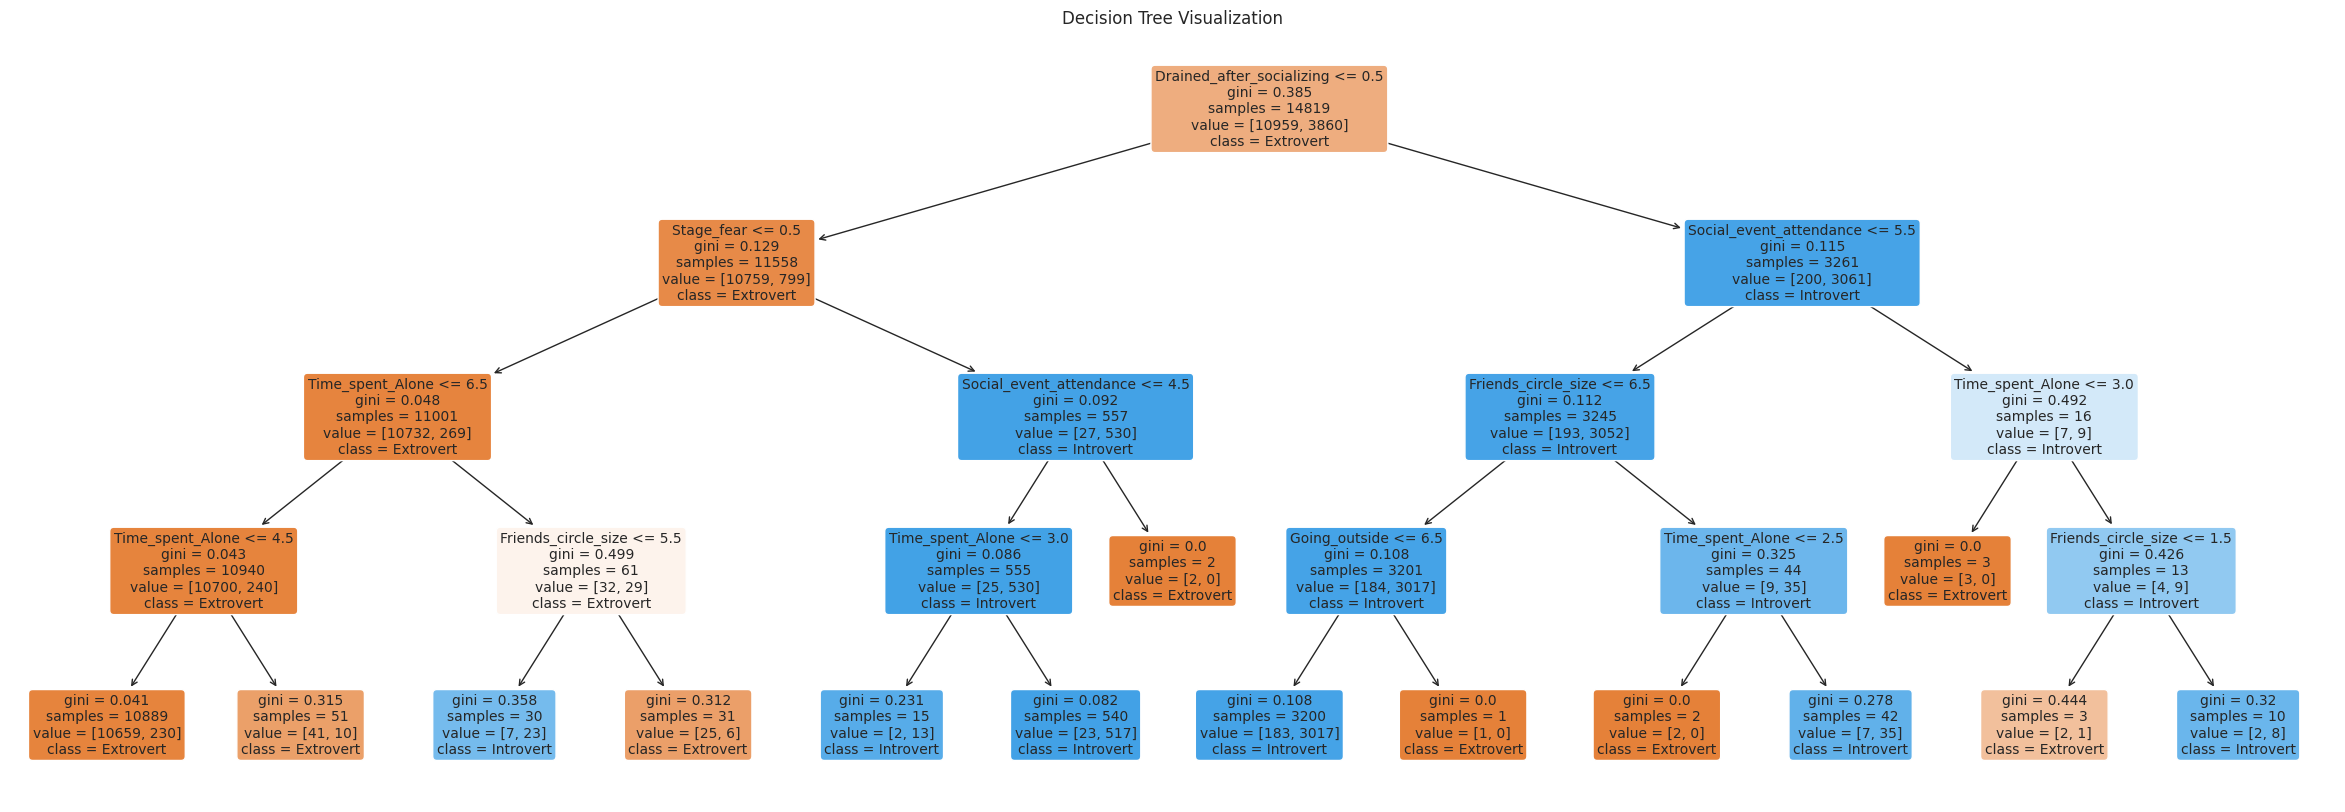

In [70]:
# Tree visualization
plt.figure(figsize=(30, 10))
plot_tree(dt_model, 
          feature_names=train_X.columns, 
          class_names=['Extrovert', 'Introvert'],
          filled=True, 
          rounded=True,
          fontsize=10)
plt.title("Decision Tree Visualization")
plt.show()

Decision Tree Model Cross-Validation Results
🔍 CV Accuracy Scores: [0.96896086 0.9659919  0.96464238 0.9705803  0.97057235]


<Figure size 600x400 with 0 Axes>

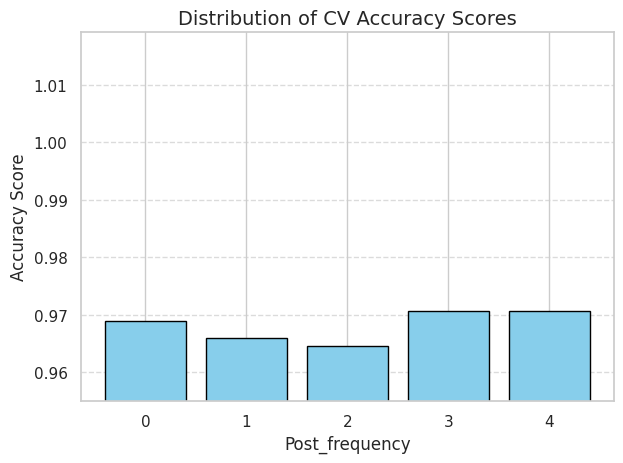

✅ Mean CV Accuracy: 0.9681495585616309
📉 Std CV Accuracy: 0.0024245600519222075
🔍 CV Weighted F1 Scores: [0.96894519 0.96588749 0.96452769 0.97048487 0.9706067 ]


<Figure size 600x400 with 0 Axes>

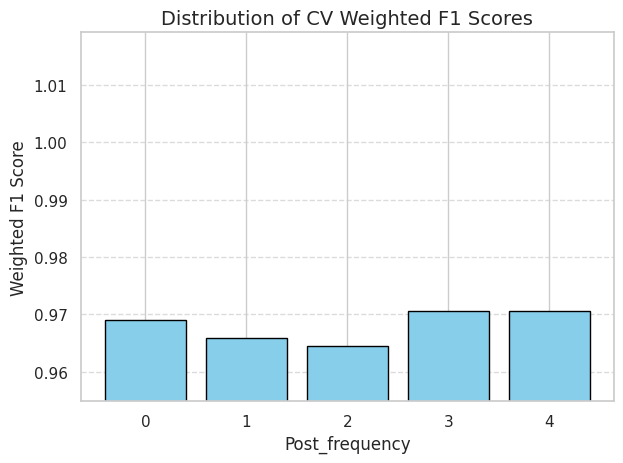

✅ Mean CV Weighted F1 Score: 0.9680903892978734
📉 Std CV Weighted F1 Score: 0.002463398096830118

🧪 Full Data Accuracy: 0.9691751241632477
🧪 Full Data Weighted F1 Score: 0.9691239798964533

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9775    0.9809    0.9792     13699
           1     0.9454    0.9358    0.9405      4825

    accuracy                         0.9692     18524
   macro avg     0.9614    0.9583    0.9599     18524
weighted avg     0.9691    0.9692    0.9691     18524



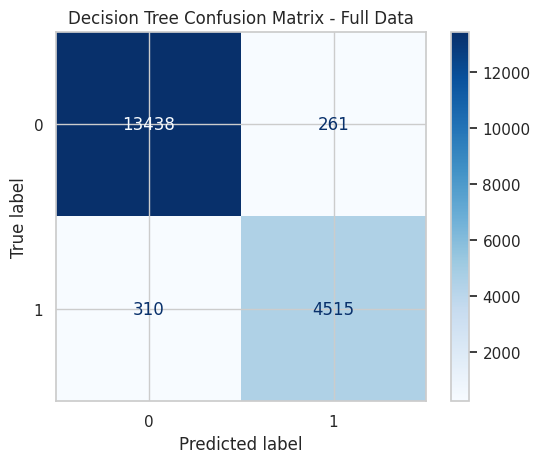

⚠️ Decision Tree model does not support direct feature importance.


In [77]:
# Define a decision tree model
dt_model = DecisionTreeClassifier(random_state=1, max_depth=4)

# Run cv_analysis
cv_analysis(dt_model, "Decision Tree")

## Second Model : Random Forest Classifier

In [71]:
# Import helpful libraries
from sklearn.ensemble import RandomForestClassifier

# Define a random forest model
rf_model = RandomForestClassifier(random_state=1)
rf_model.fit(train_X, train_y)
rf_val_predictions = rf_model.predict(val_X)

In [72]:
# Accuracy score
accuracy_score(val_y, rf_val_predictions)

0.9692307692307692

In [73]:
# Confusion matrix
confusion_matrix(y_true=val_y, y_pred=rf_val_predictions)

array([[2690,   50],
       [  64,  901]])

In [74]:
# Classification report
classification_report(y_true=val_y, y_pred=rf_val_predictions, target_names=['Extrovert', 'Introvert'])

'              precision    recall  f1-score   support\n\n   Extrovert       0.98      0.98      0.98      2740\n   Introvert       0.95      0.93      0.94       965\n\n    accuracy                           0.97      3705\n   macro avg       0.96      0.96      0.96      3705\nweighted avg       0.97      0.97      0.97      3705\n'

Max Testing Accuracy:  0.9697705802968961 , number of trees:  180


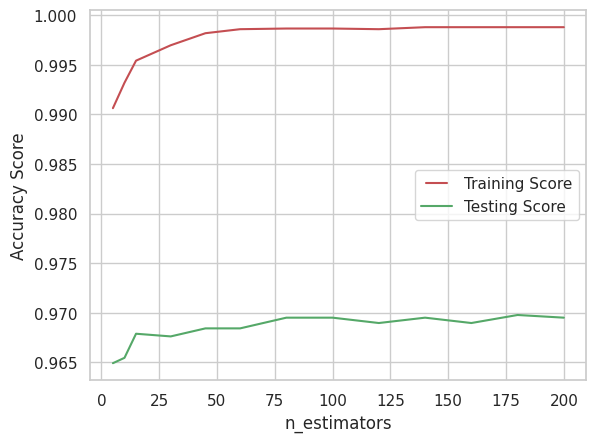

In [75]:
from matplotlib.legend_handler import HandlerLine2D

train_results = []
test_results = []
list_nb_trees = [5, 10, 15, 30, 45, 60, 80, 100, 120, 140, 160, 180, 200]

for nb_trees in list_nb_trees:
    rf = RandomForestClassifier(n_estimators=nb_trees)
    rf.fit(train_X, train_y)

    train_results.append(accuracy_score(train_y, rf.predict(train_X)))
    test_results.append(accuracy_score(val_y, rf.predict(val_X)))

print("Max Testing Accuracy: ", max(test_results), ", number of trees: ", list_nb_trees[np.argmax(test_results)])

line1, = plt.plot(list_nb_trees, train_results, color="r", label="Training Score")
line2, = plt.plot(list_nb_trees, test_results, color="g", label="Testing Score")

plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel('Accuracy Score')
plt.xlabel('n_estimators')
plt.show()

Random Forest Classifier Model Cross-Validation Results
🔍 CV Accuracy Scores: [0.96815115 0.96545209 0.96437247 0.96896086 0.96895248]


<Figure size 600x400 with 0 Axes>

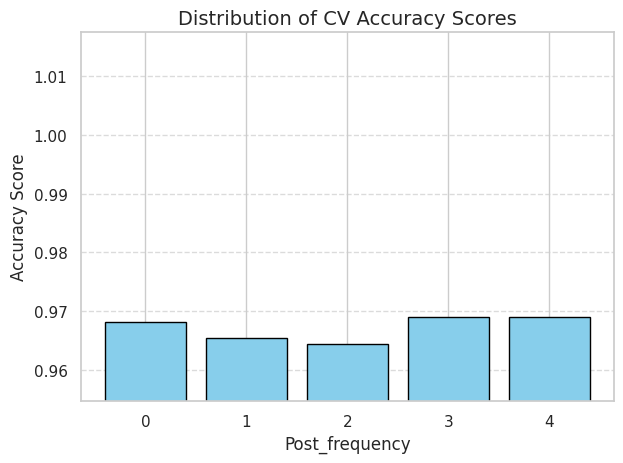

✅ Mean CV Accuracy: 0.9671778112002052
📉 Std CV Accuracy: 0.0019038997176265774
🔍 CV Weighted F1 Scores: [0.96816182 0.96536989 0.96427542 0.96888167 0.96901942]


<Figure size 600x400 with 0 Axes>

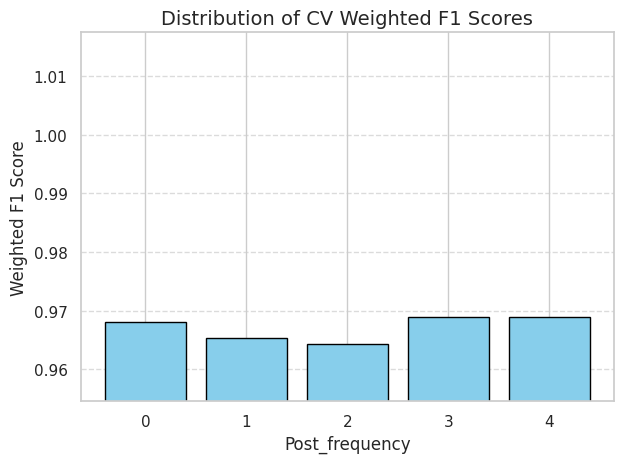

✅ Mean CV Weighted F1 Score: 0.9671416421638064
📉 Std CV Weighted F1 Score: 0.001946733019527163

🧪 Full Data Accuracy: 0.9981645432951847
🧪 Full Data Weighted F1 Score: 0.9981626851427534

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9977    0.9999    0.9988     13699
           1     0.9996    0.9934    0.9965      4825

    accuracy                         0.9982     18524
   macro avg     0.9986    0.9966    0.9976     18524
weighted avg     0.9982    0.9982    0.9982     18524



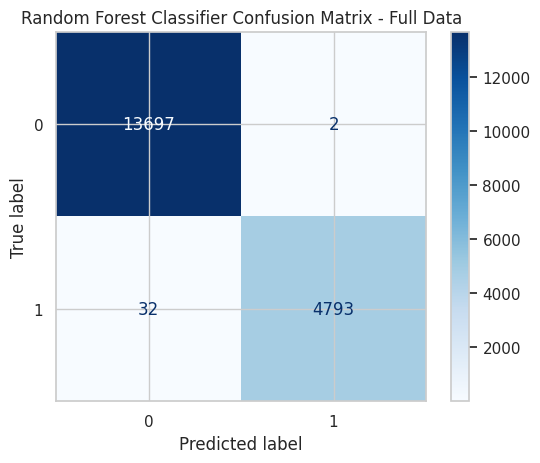

⚠️ Random Forest Classifier model does not support direct feature importance.


In [78]:
# Define a random forest classifier model
rf_model = RandomForestClassifier(random_state=1)

# Run cv_analysis
cv_analysis(rf_model, "Random Forest Classifier")

## Third Model : CatBoost

CatBoost Model Cross-Validation Results
🔍 CV Accuracy Scores: [0.96977058 0.96680162 0.96518219 0.9705803  0.97030238]


<Figure size 600x400 with 0 Axes>

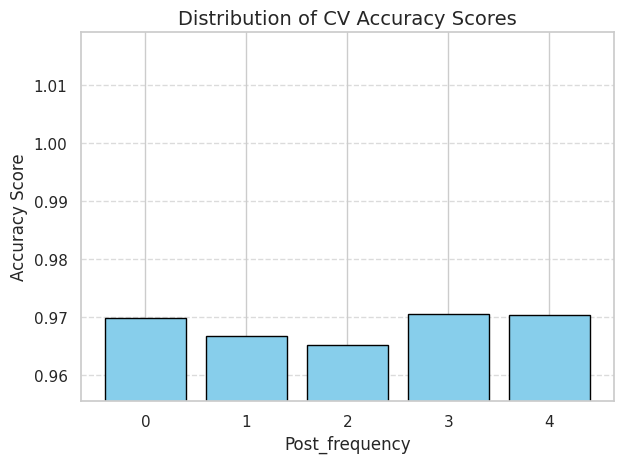

✅ Mean CV Accuracy: 0.9685274117341868
📉 Std CV Accuracy: 0.0021484504062804417
🔍 CV Weighted F1 Scores: [0.96976042 0.96670544 0.96509335 0.97045406 0.97033211]


<Figure size 600x400 with 0 Axes>

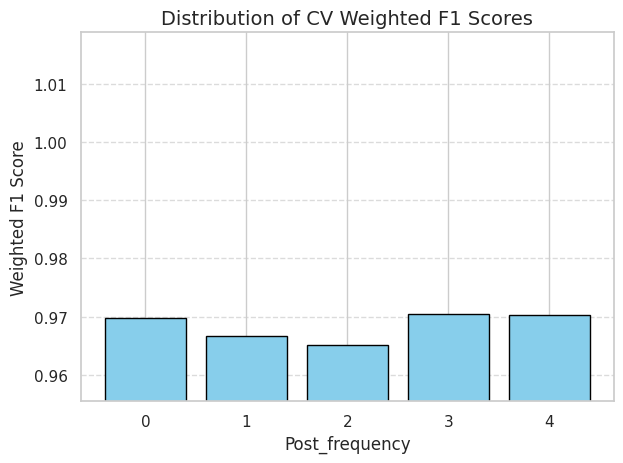

✅ Mean CV Weighted F1 Score: 0.9684690750940292
📉 Std CV Weighted F1 Score: 0.0021718454061800292

🧪 Full Data Accuracy: 0.9705247246814943
🧪 Full Data Weighted F1 Score: 0.9704748126210864

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9783    0.9819    0.9801     13699
           1     0.9481    0.9382    0.9431      4825

    accuracy                         0.9705     18524
   macro avg     0.9632    0.9601    0.9616     18524
weighted avg     0.9704    0.9705    0.9705     18524



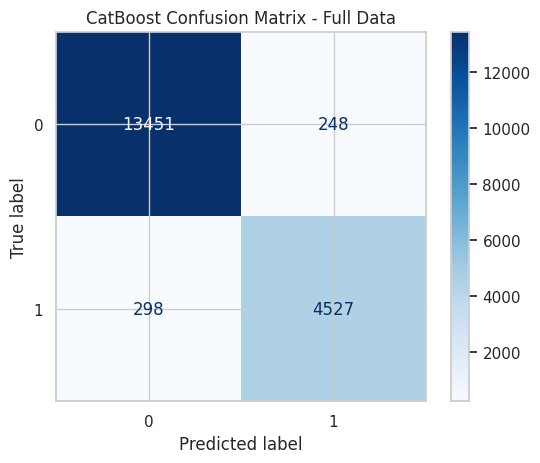


📊 CatBoost Feature Importances:
                         Feature  Importance
1                     Stage_fear   19.006329
4      Drained_after_socializing   17.796294
0               Time_spent_Alone   15.665223
2        Social_event_attendance   11.809058
5            Friends_circle_size   11.765804
3                  Going_outside   10.128835
6                 Post_frequency    8.423571
7          Time_spent_Alone_null    2.025185
8   Social_event_attendance_null    1.418212
10      Friends_circle_size_null    0.746550
11           Post_frequency_null    0.622060
9             Going_outside_null    0.592880


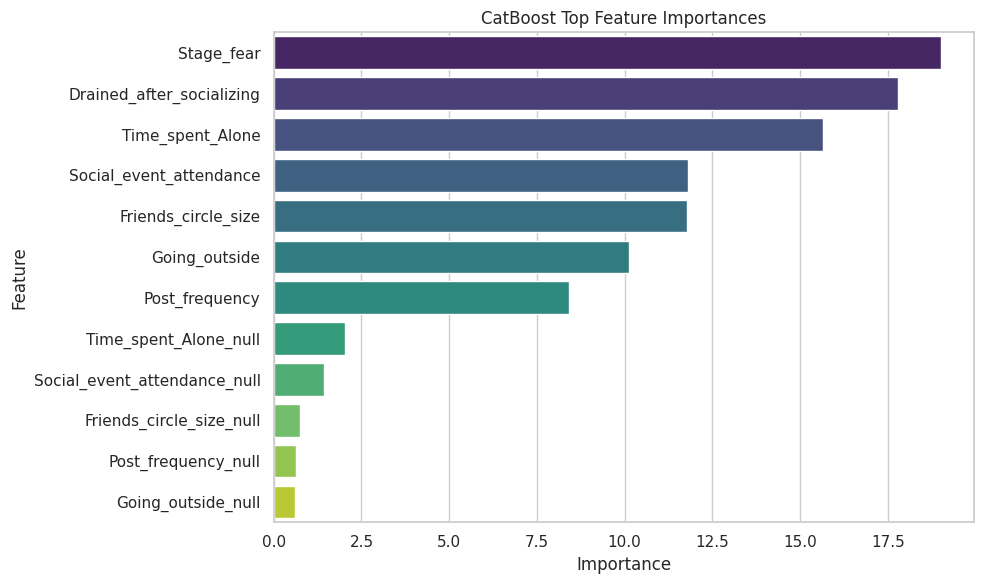

In [79]:
# Import helpful libraries
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=False
)

# Run cv_analysis
cv_analysis(cat_model, "CatBoost")

## Fourth Model : XGBoost

XGBoost Model Cross‑Validation Results
🔍 CV Accuracy Scores: [0.96950067 0.96653171 0.965722   0.9705803  0.97192225]


<Figure size 600x400 with 0 Axes>

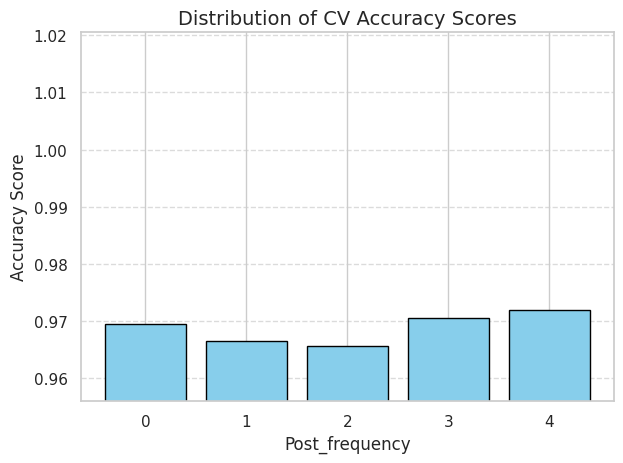

✅ Mean CV Accuracy: 0.9688513858162603
📉 Std CV Accuracy: 0.0023670590849722483
🔍 CV F1 Scores: [0.94142043 0.93528184 0.93361213 0.94284216 0.94633643]


<Figure size 600x400 with 0 Axes>

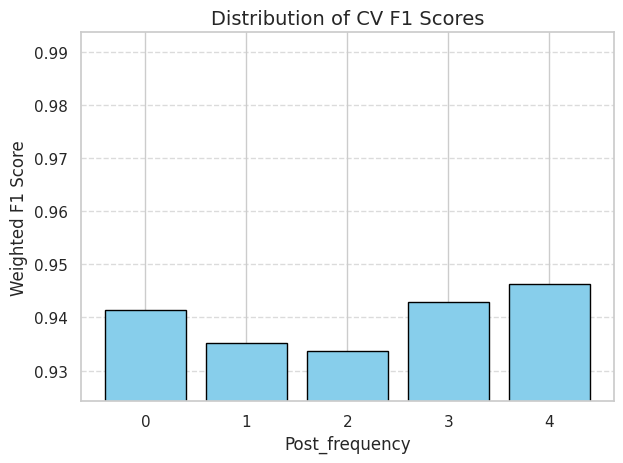

✅ Mean CV F1 Score: 0.9398985959139697
📉 Std CV F1 Score: 0.004759419733587785

🧪 Full Data Accuracy: 0.9689591880803282
🧪 Full Data Weighted F1 Score: 0.9689098054400943

📋 Classification Report:
               precision    recall  f1-score   support

           0     0.9774    0.9807    0.9790     13699
           1     0.9447    0.9355    0.9401      4825

    accuracy                         0.9690     18524
   macro avg     0.9611    0.9581    0.9596     18524
weighted avg     0.9689    0.9690    0.9689     18524



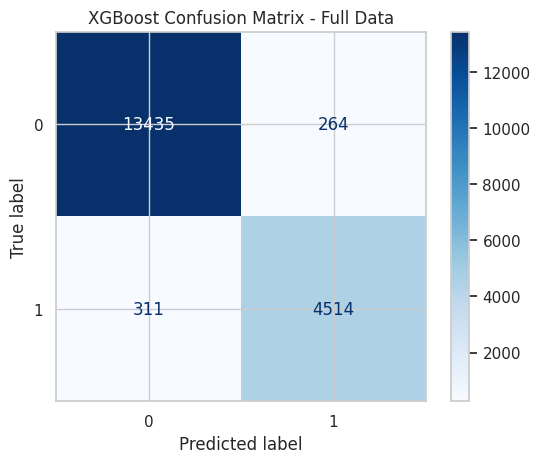


📊 XGBoost Feature Importances:
                          Feature  Importance
4      Drained_after_socializing    0.426051
1                     Stage_fear    0.198442
0               Time_spent_Alone    0.194731
2        Social_event_attendance    0.098993
6                 Post_frequency    0.021985
9             Going_outside_null    0.019816
3                  Going_outside    0.016561
11           Post_frequency_null    0.007546
5            Friends_circle_size    0.007317
7          Time_spent_Alone_null    0.005343
8   Social_event_attendance_null    0.002100
10      Friends_circle_size_null    0.001114


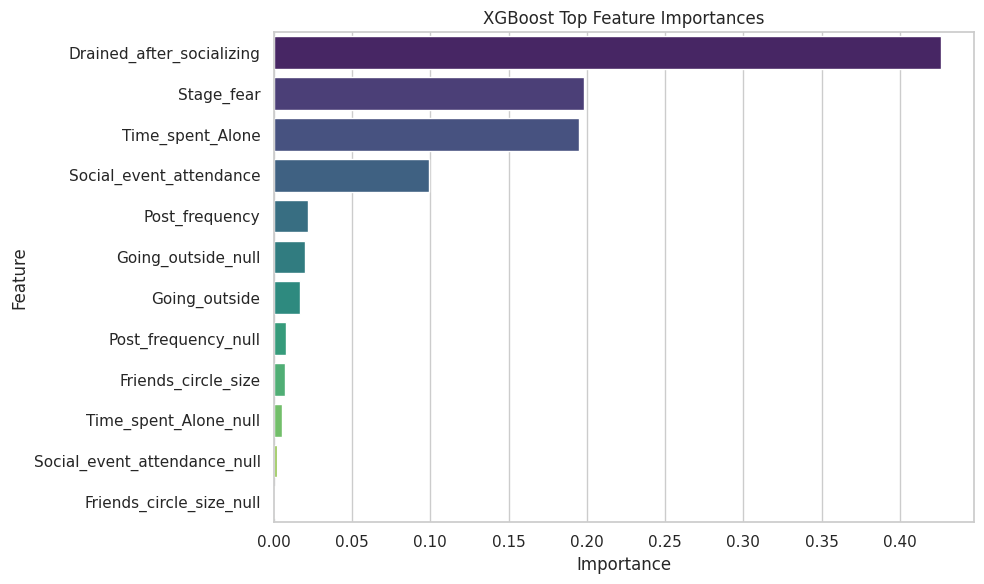

In [112]:
# Import helpful libraries
from xgboost import XGBClassifier
import xgboost as xgb

# 1) Define your model exactly once:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    tree_method='hist',
    predictor='gpu_predictor',
    enable_categorical=False,
    random_state=42,
    n_estimators=1000,
    learning_rate=0.006358,
    max_depth=8,
    subsample=0.8854,
    colsample_bytree=0.6,
    reg_lambda=0.8295,
    reg_alpha=5.5149,
    gamma=0.0395,
    min_child_weight=2,
    use_label_encoder=False
)

# 2) Set up CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 3) Cross‑val scoring
cv_accuracy_scores = []
cv_f1_scores = []
for train_index, test_index in cv.split(X_tf, y_tf):   
    cv_X_train, cv_X_test = X_tf.iloc[train_index], X_tf.iloc[test_index]
    cv_y_train, cv_y_test = y_tf[train_index], y_tf[test_index]

    xgb_model.fit(cv_X_train, cv_y_train)
    
    cv_y_pred = xgb_model.predict(cv_X_test)
    
    cv_accuracy_scores.append(accuracy_score(cv_y_test, cv_y_pred))
    cv_f1_scores.append(f1_score(cv_y_test, cv_y_pred))

cv_accuracy_scores = np.array(cv_accuracy_scores)
cv_f1_scores = np.array(cv_f1_scores)
print("XGBoost Model Cross‑Validation Results")
print("🔍 CV Accuracy Scores:", cv_accuracy_scores)
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
ax.bar(range(5), cv_accuracy_scores, color='skyblue', edgecolor='black')
ax.set_ylim(bottom=0.99*min(cv_accuracy_scores))
plt.title(f'Distribution of CV Accuracy Scores', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Accuracy Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("✅ Mean CV Accuracy:", cv_accuracy_scores.mean())
print("📉 Std CV Accuracy:", cv_accuracy_scores.std())

print("🔍 CV F1 Scores:", cv_f1_scores)
plt.figure(figsize=(6, 4))
fig, ax = plt.subplots()
ax.bar(range(5), cv_f1_scores, color='skyblue', edgecolor='black')
ax.set_ylim(bottom=0.99*min(cv_f1_scores))
plt.title(f'Distribution of CV F1 Scores', fontsize=14)
plt.xlabel(col, fontsize=12)
plt.ylabel('Weighted F1 Score', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("✅ Mean CV F1 Score:", cv_f1_scores.mean())
print("📉 Std CV F1 Score:", cv_f1_scores.std())

# 4) Train on full data
xgb_model.fit(X_tf, y_tf)

# 5) Predict on the same data (just for demonstration; normally you'd have hold‑out)
y_pred = xgb_model.predict(X_tf)

# 6) Report metrics
test_accuracy = accuracy_score(y_tf, y_pred)
test_f1 = f1_score(y_tf, y_pred, average='weighted')
print("\n🧪 Full Data Accuracy:", test_accuracy)
print("🧪 Full Data Weighted F1 Score:", test_f1)
print("\n📋 Classification Report:\n",
      classification_report(y_tf, y_pred, digits=4))

# 7) Plot confusion matrix
cm = confusion_matrix(y_tf, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=xgb_model.classes_)
disp.plot(cmap='Blues')
plt.title("XGBoost Confusion Matrix - Full Data")
plt.show()

# 8) Feature importances
importances = xgb_model.feature_importances_
feature_names = (X_tf.columns 
                 if hasattr(X_tf, 'columns') 
                 else [f"Feature {i}" for i in range(X_tf.shape[1])])
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n📊 XGBoost Feature Importances:\n", feature_importance_df)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance_df, 
    palette='viridis'
)
plt.title('XGBoost Top Feature Importances')
plt.tight_layout()
plt.show()

## Fifth Model : LightGBM

In [ ]:
# Import helpful libraries
import lightgbm as lgb
# To Be Done (WIP)

# Model Fitting on Submission Data
From those models, I think that the CatBoost model is the best one. That's why I use that as my model for my submission.

In [99]:
# To improve accuracy, create a new CatBoost model which you will train on all training data
cat_model_on_full_data = cat_model = CatBoostClassifier(
    iterations=300,
    learning_rate=0.1,
    depth=4,
    random_seed=42,
    verbose=False
)

# fit rf_model_on_full_data on all data from the training data
cat_model_on_full_data.fit(X_tf, y_tf)

## Submission Model Prediction

In [106]:
# Describe test data
test_df.describe()

,id,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,6175.000000,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,21611.000000,3.116870,5.287989,4.037835,8.008412,5.028958
std,1782.713288,2.985658,2.758052,2.045207,4.192701,2.867285
min,18524.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20067.500000,1.000000,3.000000,3.000000,5.000000,3.000000
50%,21611.000000,2.000000,5.000000,4.000000,8.000000,5.000000
75%,23154.500000,4.000000,8.000000,6.000000,12.000000,7.000000
max,24698.000000,11.000000,10.000000,7.000000,15.000000,10.000000


In [107]:
# Create test_X which comes from test_data but includes only the columns used for prediction
test_X = test_df.drop(columns=['id'], errors='ignore')
test_X.describe()

,Time_spent_Alone,Social_event_attendance,Going_outside,Friends_circle_size,Post_frequency
count,5750.000000,5778.000000,5709.000000,5825.000000,5767.000000
mean,3.116870,5.287989,4.037835,8.008412,5.028958
std,2.985658,2.758052,2.045207,4.192701,2.867285
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,3.000000,3.000000,5.000000,3.000000
50%,2.000000,5.000000,4.000000,8.000000,5.000000
75%,4.000000,8.000000,6.000000,12.000000,7.000000
max,11.000000,10.000000,7.000000,15.000000,10.000000


In [108]:
# Transform the test data
test_X_tf = null_transformer(test_X)
test_X_tf.describe()

,Time_spent_Alone,Stage_fear,Social_event_attendance,Going_outside,Drained_after_socializing,Friends_circle_size,Post_frequency,Time_spent_Alone_null,Social_event_attendance_null,Going_outside_null,Friends_circle_size_null,Post_frequency_null
count,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000,6175.000000
mean,2.902348,0.217166,4.948016,3.733117,0.211498,7.554494,4.696680,0.068826,0.064291,0.075466,0.056680,0.066073
std,2.987180,0.412350,2.966510,2.237161,0.408404,4.473465,3.039554,0.253178,0.245291,0.264163,0.231249,0.248430
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,3.000000,2.000000,0.000000,4.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,0.000000,5.000000,4.000000,0.000000,8.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,4.000000,0.000000,7.000000,6.000000,0.000000,11.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,11.000000,1.000000,10.000000,7.000000,1.000000,15.000000,10.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [109]:
# Make predictions which will be submitted 
test_preds_tf = cat_model_on_full_data.predict(test_X_tf)
print(test_preds_tf)

[0 1 0 ... 0 0 1]


In [110]:
# Detransform the predictions
test_preds = target_detransformer(test_preds_tf)
test_preds

array(['Extrovert', 'Introvert', 'Extrovert', ..., 'Extrovert',
       'Extrovert', 'Introvert'], dtype='<U9')

## Submission

In [111]:
# Save predictions in the format used for competition scoring
output = pd.DataFrame({'id': test_df.id,
                       'Personality': test_preds})
output.to_csv('submission.csv', index=False)